# GR00T Inference

This tutorial shows how to use the GR00T inference model to predict the actions from the observations, given a test dataset.

In [1]:
import os
import torch
import gr00t

from gr00t.data.dataset import LeRobotSingleDataset
from gr00t.model.policy import Gr00tPolicy

/home/saphari_lab/anaconda3/envs/gr00t/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/saphari_lab/anaconda3/envs/gr00t/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# change the following paths
MODEL_PATH = "nvidia/GR00T-N1-2B"

# REPO_PATH is the path of the pip install gr00t repo and one level up
REPO_PATH = os.path.dirname(os.path.dirname(gr00t.__file__))
DATASET_PATH = os.path.join(REPO_PATH, "novideo_data")
EMBODIMENT_TAG = "gr1"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Loading Pretrained Policy

Policy Model is loaded just like any other huggingface model.

There are 2 new concepts here in the GR00T model:
 - modality config: This defines the keys in the dictionary used by the model. (e.g. `action`, `state`, `annotation`, `video`)
 - modality_transform: A sequence of transform which are used during dataloading

In [3]:
from gr00t.experiment.data_config import DATA_CONFIG_MAP
from gr00t.data.dataset import ModalityConfig
from gr00t.data.transform.base import ComposedModalityTransform
from gr00t.data.transform import VideoToTensor, VideoCrop, VideoResize, VideoColorJitter, VideoToNumpy
from gr00t.data.transform.state_action import StateActionToTensor, StateActionTransform
from gr00t.data.transform.concat import ConcatTransform
from gr00t.model.transforms import GR00TTransform

observation_indices = [0]
action_indices = list(range(16))
data_config = DATA_CONFIG_MAP["gr1_arms_only"]
print(data_config)
print(data_config.modality_config())
# modality_config = data_config.modality_config()
# modality_transform = data_config.transform()
modality_config = {
    "video": ModalityConfig(
        delta_indices=[0],
        modality_keys=["video.ego_view"],
    ),
    "state": ModalityConfig(
        delta_indices=[0],
        modality_keys=[
            "state.left_arm",
            "state.right_arm"
        ],
    ),
    "action": ModalityConfig(
        delta_indices=[0],
        modality_keys=[
            "action.left_arm",
            "action.right_arm",
        ],
    ),
    "language": ModalityConfig(
        delta_indices=[0],
        modality_keys=["annotation.human.action.task_description"] #, "annotation.human.validity"],
    ),
}
video_modality = modality_config["video"]
state_modality = modality_config["state"]
action_modality = modality_config["action"]
modality_transform = ComposedModalityTransform(
    transforms=[
        # video transforms
        VideoToTensor(apply_to=video_modality.modality_keys),
        VideoCrop(apply_to=video_modality.modality_keys, scale=0.95),
        VideoResize(apply_to=video_modality.modality_keys, height=224, width=224, interpolation="linear"),
        VideoColorJitter(apply_to=video_modality.modality_keys, brightness=0.3, contrast=0.4, saturation=0.5, hue=0.08),
        VideoToNumpy(apply_to=video_modality.modality_keys),

        # state transforms
        StateActionToTensor(apply_to=state_modality.modality_keys),
        StateActionTransform(apply_to=state_modality.modality_keys, normalization_modes={
            key: "min_max" for key in state_modality.modality_keys
        }),

        # action transforms
        StateActionToTensor(apply_to=action_modality.modality_keys),
        StateActionTransform(apply_to=action_modality.modality_keys, normalization_modes={
            key: "min_max" for key in action_modality.modality_keys
        }),

        # ConcatTransform
        ConcatTransform(
            video_concat_order=video_modality.modality_keys,
            state_concat_order=state_modality.modality_keys,
            action_concat_order=action_modality.modality_keys,
        ),
        GR00TTransform(
            state_horizon=len(observation_indices),
            action_horizon=len(action_indices),
            max_state_dim=64,
            max_action_dim=32,
        )
    ]
)
policy = Gr00tPolicy(
    model_path=MODEL_PATH,
    embodiment_tag=EMBODIMENT_TAG,
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

# print out the policy model architecture
print(policy.model)

2025-04-11 15:49:16.093929: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 15:49:16.111818: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-11 15:49:16.111841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-11 15:49:16.112298: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-11 15:49:16.115389: I tensorflow/core/platform/cpu_feature_guar

{'video': ModalityConfig(delta_indices=[0], modality_keys=['video.ego_view']), 'state': ModalityConfig(delta_indices=[0], modality_keys=['state.left_arm', 'state.right_arm', 'state.left_hand', 'state.right_hand']), 'action': ModalityConfig(delta_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], modality_keys=['action.left_arm', 'action.right_arm', 'action.left_hand', 'action.right_hand']), 'language': ModalityConfig(delta_indices=[0], modality_keys=['annotation.human.action.task_description'])}


Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 178481.02it/s]

Loading pretrained dual brain from /home/saphari_lab/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: /home/saphari_lab/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb



/home/saphari_lab/Repositories/Isaac-GR00T/gr00t/model/action_head/cross_attention_dit.py:249: FutureWarning: Accessing config attribute `output_dim` directly via 'DiT' object attribute is deprecated. Please access 'output_dim' over 'DiT's config object instead, e.g. 'unet.config.output_dim'.
  self.proj_out_2 = nn.Linear(self.inner_dim, self.output_dim)


Total number of DiT parameters:  537803776


Some weights of the model checkpoint at /home/saphari_lab/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb were not used when initializing GR00T_N1: ['action_head.decode_layer.bias', 'action_head.decode_layer.weight']
- This IS expected if you are initializing GR00T_N1 from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GR00T_N1 from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Tune action head projector: True
Tune action head diffusion model: True
Tune action head projector: True
Tune action head diffusion model: True
GR00T_N1(
  (backbone): EagleBackbone(
    (model): Eagle2ChatModel(
      (vision_model): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(256, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (self_attn): SiglipFlashAttention2(
                  (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (out_proj): Linear(in_features=1152, out_feat

## Loading dataset

First this requires user to check which embodiment tags are used to pretrained the `Gr00tPolicy` pretrained models.

In [4]:
import numpy as np

modality_config = policy.modality_config

print(modality_config.keys())

for key, value in modality_config.items():
    if isinstance(value, np.ndarray):
        print(key, value.shape)
    else:
        print(key, value)


dict_keys(['video', 'state', 'action', 'language'])
video delta_indices=[0] modality_keys=['video.ego_view']
state delta_indices=[0] modality_keys=['state.left_arm', 'state.right_arm']
action delta_indices=[0] modality_keys=['action.left_arm', 'action.right_arm']
language delta_indices=[0] modality_keys=['annotation.human.action.task_description']


In [5]:
# Create the dataset
dataset = LeRobotSingleDataset(
    dataset_path=DATASET_PATH,
    modality_configs=modality_config,
    video_backend="decord",
    video_backend_kwargs=None,
    transforms=None,  # We'll handle transforms separately through the policy
    embodiment_tag=EMBODIMENT_TAG,
)

Initialized dataset novideo_data with gr1


Let's print out a single data and visualize it

In [6]:
import numpy as np

step_data = dataset[0]

print(step_data)

print("\n\n ====================================")
for key, value in step_data.items():
    if isinstance(value, np.ndarray):
        print(key, value.shape)
    else:
        print(key, value)


{'video.ego_view': array([[[[173, 166, 157],
         [173, 166, 157],
         [173, 166, 157],
         ...,
         [195, 190, 183],
         [193, 188, 181],
         [193, 188, 181]],

        [[173, 166, 157],
         [173, 166, 157],
         [173, 166, 157],
         ...,
         [195, 190, 183],
         [193, 188, 181],
         [193, 188, 181]],

        [[173, 166, 157],
         [173, 166, 157],
         [173, 166, 157],
         ...,
         [195, 190, 183],
         [193, 188, 181],
         [193, 188, 181]],

        ...,

        [[170, 179, 124],
         [171, 180, 125],
         [177, 185, 138],
         ...,
         [223, 221, 215],
         [223, 221, 215],
         [223, 221, 215]],

        [[169, 178, 123],
         [171, 180, 125],
         [177, 186, 131],
         ...,
         [223, 221, 215],
         [223, 221, 215],
         [223, 221, 215]],

        [[169, 178, 123],
         [171, 180, 125],
         [177, 186, 131],
         ...,
         [223, 

Let's plot just the "right hand" state and action data and see how it looks like. Also show the images of the right hand state.

100%|██████████| 700/700 [00:06<00:00, 102.36it/s]


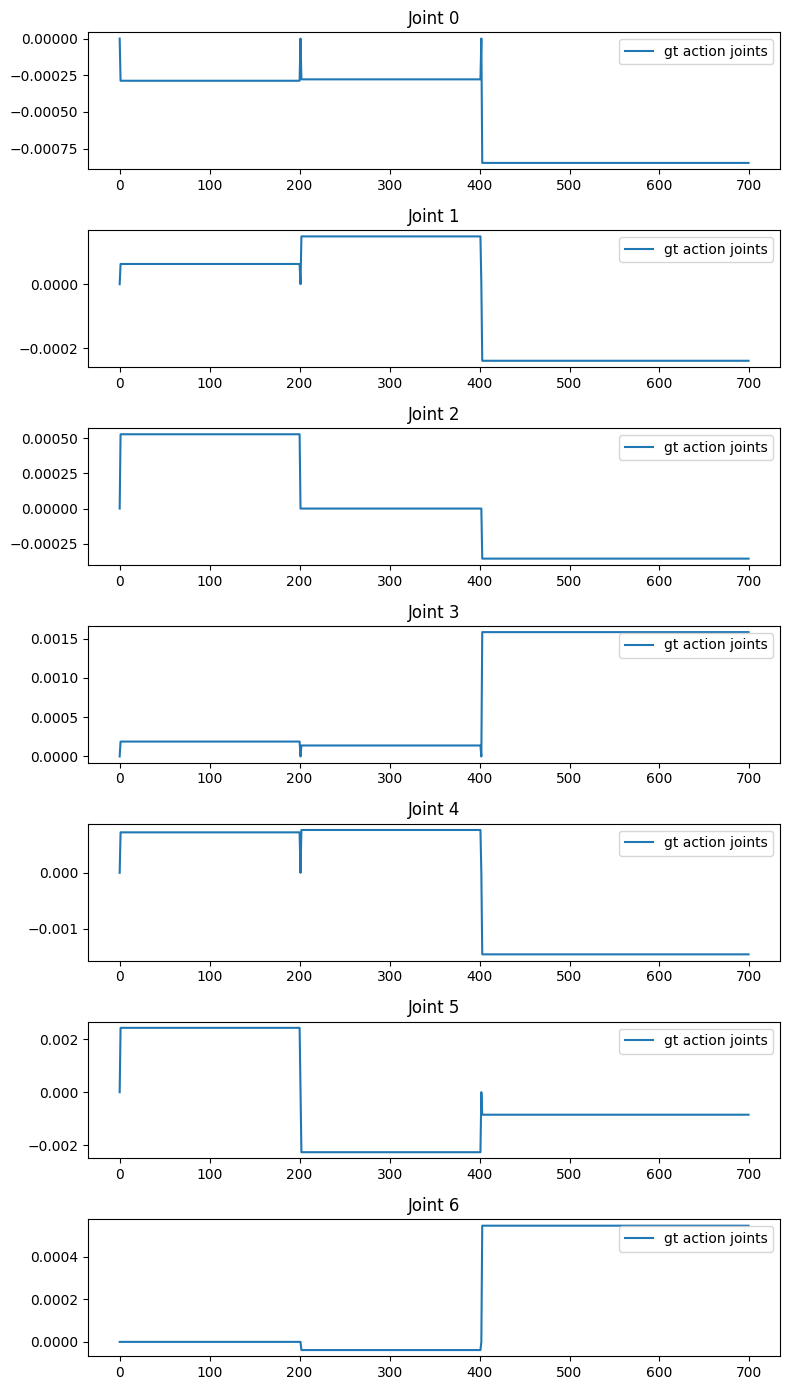

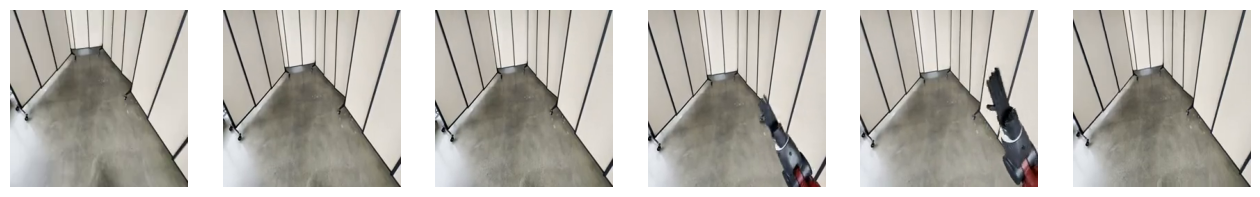

In [7]:
import matplotlib.pyplot as plt
from tqdm import tqdm
traj_id = 3
max_steps = 700

state_joints_across_time = []
gt_action_joints_across_time = []
images = []

sample_images = 6
for step_count in tqdm(range(max_steps)):
    data_point = dataset.get_step_data(traj_id, step_count)
    state_joints = data_point["state.right_arm"][0]
    gt_action_joints = data_point["action.right_arm"][0]
    

    state_joints_across_time.append(state_joints)
    gt_action_joints_across_time.append(gt_action_joints)

    # We can also get the image data
    if step_count % (max_steps // sample_images) == 0:
        image = data_point["video.ego_view"][0]
        images.append(image)

# Size is (max_steps, num_joints == 7)
state_joints_across_time = np.array(state_joints_across_time)
gt_action_joints_across_time = np.array(gt_action_joints_across_time)


# Plot the joint angles across time
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 2*7))

for i, ax in enumerate(axes):
    # ax.plot(state_joints_across_time[:, i], label="state joints")
    ax.plot(gt_action_joints_across_time[:, i], label="gt action joints")
    ax.set_title(f"Joint {i}")
    ax.legend()

plt.tight_layout()
plt.show()


# Plot the images in a row
fig, axes = plt.subplots(nrows=1, ncols=sample_images, figsize=(16, 4))

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis("off")
    

Now we can run the policy from the pretrained checkpoint.

In [8]:
print(dataset._trajectory_ids)

[0 1 2 3]


In [9]:
predicted_action = policy.get_action(step_data)
values = True
for key, value in predicted_action.items():
    print(key, value.shape)
    if values is True:
        values = value
print(values)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


action.left_arm (16, 7)
action.right_arm (16, 7)
[[-0.2428875   0.32711703  0.08236742 -0.38469911  0.0110724   0.25600886
  -0.61872083]
 [-0.25011897  0.3529827   0.12620711 -0.35721517  0.009269    0.26039433
  -0.61872083]
 [-0.24107957  0.37145817  0.08445501 -0.41218281  0.04954672  0.24723792
  -0.6216386 ]
 [-0.23204017  0.3529827   0.08445501 -0.43966651  0.03632116  0.26331806
  -0.615803  ]
 [-0.26006222  0.32342193  0.05940366 -0.45065999  0.03331542  0.27647448
  -0.63330978]
 [-0.23384809  0.36776307  0.09698057 -0.41767955  0.05135012  0.26624167
  -0.62747419]
 [-0.23927164  0.37145817  0.06775427 -0.42867303  0.05195141  0.27062714
  -0.61872083]
 [-0.23204017  0.38623855  0.0886302  -0.41218281  0.06637907  0.28524542
  -0.64789873]
 [-0.25915837  0.3566778   0.07819223 -0.41767955  0.01347709  0.29547822
  -0.65665209]
 [-0.22842431  0.38254344  0.10324335 -0.41767955  0.04413629  0.29401636
  -0.63330978]
 [-0.23565602  0.39362872  0.09489298 -0.38469911  0.06487632

### Understanding the Action Output

Each joint in the action output has a shape of (16, N) where N is the degree of freedom for the joint.
- 16 represents the action horizon (predictions for timesteps t, t+1, t+2, ..., t+15)

For each arm (left and right):
- 7 arm joints:
  - Shoulder pitch
  - Shoulder roll
  - Shoulder yaw
  - Elbow pitch
  - Wrist yaw
  - Wrist roll
  - Wrist pitch

For each hand (left and right):
- 6 finger joints:
  - Little finger
  - Ring finger
  - Middle finger
  - Index finger
  - Thumb rotation
  - Thumb bending

For the waist
- 3 joints:
  - torso waist yaw
  - torso waist pitch
  - torso waist roll
